In [0]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:


imsize = 200 
is_cuda = torch.cuda.is_available()

prep = transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img



In [0]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(prep(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [0]:
style_img = image_loader("/content/mona.jpg")
content_img = image_loader("/content/modi.jpg")
vgg = vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_img = style_img.cuda()
    content_img = content_img.cuda()
    vgg = vgg.cuda()

opt_img = Variable(content_img.data.clone(),requires_grad=True)

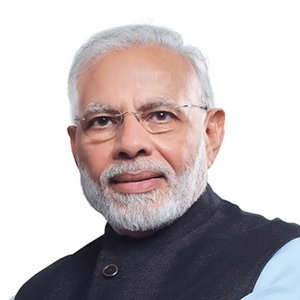

In [0]:
## content Image  

Image.open('/content/modi.jpg').resize((300,300))

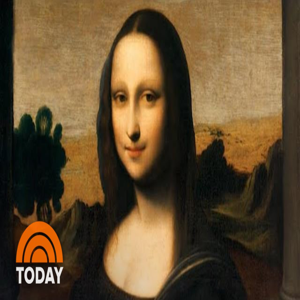

In [0]:
## style Image
Image.open('/content/mona.jpg').resize((300,300))

**We Dont Need classifier part of model because We are not classifying Images we need only features**

In [0]:


style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers



In [0]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

**We are freeze parameters of model beacuse We dont need to train model**

In [0]:


class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)



**so , In summary we created a VGG model, used only its convolution blocks and froze all the parameters of the model, as we will be using it only for extracting features.**

**Now defining style loss**

In [0]:


def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features


content_targets = extract_layers(content_layers,content_img,model=vgg)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_img,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets



In [0]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.cuda() for fn in loss_fns]

In [0]:


#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights



In [0]:


#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,opt_img,model=vgg)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss
    
    optimizer.step(closure)



Iteration: 50, loss: 213551.203125
Iteration: 100, loss: 62336.148438
Iteration: 150, loss: 45479.906250
Iteration: 200, loss: 39397.968750
Iteration: 250, loss: 36488.515625
Iteration: 300, loss: 34998.398438
Iteration: 350, loss: 34055.394531
Iteration: 400, loss: 33416.125000
Iteration: 450, loss: 32945.246094
Iteration: 500, loss: 32579.322266


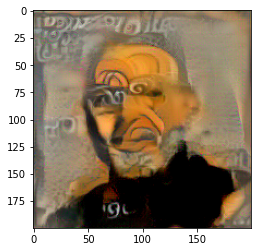

In [0]:
out_img_hr = postp(opt_img.data[0].cpu().squeeze())

imshow(out_img_hr)
